# Modeling the Joint Distribution of Wind Speed and Direction  using Gaussain Mixture Models

OEN Method: Harris, Cook
The parent wind speed distribution: Why Weibull?
http://www.sciencedirect.com/science/article/pii/S0167610514001056

Gaussian Mixture Models, 
http://scikit-learn.org/stable/modules/mixture.html

# 1. Set up

## 1.1 Environment

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from import_file import *
from helpers.parallel_helper import *
load_libs()

plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
plt.rcParams['axes.xmargin'] = 0.
plt.rcParams['axes.ymargin'] = 0.

## 1.2 Read Data

In [2]:
# file_path= "./data/NCDC/us/baltimore/dat.txt" # time too short
# file_path= './data/NCDC/uk/boscombe_down/dat.txt' # 4?
# file_path= './data/NCDC/uk/middle_wallop/dat.txt' # good
# file_path= './data/NCDC/uk/southhamption/dat.txt' # high 0
# file_path= './data/NCDC/uk/bournemouth/dat.txt' 4?
# file_path= './data/NCDC/uk/tiree/dat.txt'  # try 4
# file_path= "./data/NCDC/uk/bealach_na_ba/dat.txt" # 
# file_path= "./data/NCDC/uk/skye_lusa/dat.txt" # 
# file_path= "./data/NCDC/uk/south_uist_range/dat.txt" 
# file_path= './data/NCDC/uk/marham/dat.txt' 
# file_path= "./data/NCDC/uk/holbeach/dat.txt"
# file_path= "./data/NCDC/uk/weybourne/dat.txt"
# file_path= "./data/NCDC/uk/cambridge/dat.txt"
# file_path= "./data/NCDC/uk/wattisham/dat.txt"
# file_path= "./data/NCDC/uk/benbecula/dat.txt" # truncate (untruncate in m/s), 4?

# file_path= "./data/NCDC/southeast_asia/singapore_changi/dat.txt" # 4 or 5?
# file_path= "./data/NCDC/southeast_asia/sultan_ismail/dat.txt" # 
# file_path= "./data/NCDC/southeast_asia/paya_lebar/dat.txt" # 2010-2014 has problem
# file_path= "./data/NCDC/east_asia/cheongju_intl/dat.txt" # 2005-2009  may have problem, fit is good
# file_path= "./data/NCDC/east_asia/daegu_ab/dat.txt" # recent 5 year may have problem, but fit is generally good

# file_path= "./data/NCDC/europe/landsberg_lech/dat.txt" # very good, can try 4
# file_path= "./data/NCDC/europe/laupheim/dat.txt" # double peak, 4; very good
# file_path= "./data/NCDC/europe/vatry/dat.txt"  # double peak, initial speed (should be good with m/s)
# file_path= "./data/NCDC/europe/avord/dat.txt" # try 4, initial speed (should be good with m/s)
# file_path= './data/NCDC/europe/ciampino/dat.txt' # try 4, bandwidth?
# file_path= "./data/NCDC/europe/holzdorf/dat.txt"
# file_path= "./data/NCDC/europe/neuburg/dat.txt"
# file_path= "./data/NCDC/europe/valladolid/dat.txt"
# file_path= "./data/NCDC/europe/barayas/dat.txt" # 
# file_path= "./data/NCDC/europe/huspel_aws/dat.txt"  # integer, 4?
# file_path= "./data/NCDC/europe/diepholz/dat.txt" # recent year is integer with less data, use m/s
# file_path= './data/NCDC/europe/tenerife_sur/dat.txt'  # some directions are blocked

# file_path= "./data/NCDC/oceania/narrandera/dat.txt" # high 0
# file_path= "./data/NCDC/oceania/brisbane_archerfield/dat.txt" # high 0
# file_path= "./data/NCDC/oceania/auckland_intl/dat.txt"  # Weird KDE shape, 4?
# file_path= "./data/NCDC/oceania/canberra/dat.txt" # high 0

# file_path= "./data/NCDC/cn/shanghai/hongqiao_intl/dat.txt" 
# file_path= "./data/NCDC/cn/shanghai/pudong/dat.txt"
# file_path= "./data/NCDC/cn/tianjing/binhai/dat.txt" # recent 5 year has small problem, good overall, few 0
# file_path= "./data/NCDC/cn/tianjing/tianjing/dat.txt" # 16 sectors
# file_path= "./data/NCDC/cn/hefei_luogang/dat.txt" # recent 5 year has small problem, good overall, few 0
# file_path= "./data/NCDC/cn/南京lukou/dat.txt" 
# file_path= "./data/NCDC/cn/shijiazhuang_zhengding/dat.txt" 
# file_path= "./data/NCDC/cn/henan_gushi/dat.txt" # 16 sectors, fit not very good
# file_path= "./data/NCDC/cn/郑州xinzheng/dat.txt" # fit is not good
# file_path= "./data/NCDC/cn/nanning_wuxu/dat.txt" # recent 5 year has problem
# file_path= './data/NCDC/cn/macau/dat.txt'  
# file_path= "./data/NCDC/cn/hk_intl/dat.txt" # few initial data

# file_path= "./data/cn_database/广州.txt" 
# file_path= "./data/cn_database/北京.txt" 

# file_path = 'TOP/hr_avg.csv' # High 0
# file_path = './data/asos/denver/hr_avg.csv' # few 0 

# file_path = './data/asos/bismarck_ND/hr_avg.csv' 
file_path = './data/asos/bismarck_ND/minute_avg.csv' 
# file_path = './data/asos/aberdeen_SD/hr_avg.csv' # only to 2012
# file_path = './data/asos/minneapolis/hr_avg.csv'

# file_path = './data/asos/lincoln_NE/hr_avg.csv' 
# file_path = './data/asos/des_moines_IA/hr_avg.csv'
# file_path = './data/asos/springfield_IL/hr_avg.csv'

In [3]:
if "cn_database" in file_path: 
    df = read_cn_database(file_path)
elif 'NCDC' in file_path:
    df = pd.read_csv(file_path, header=0, skipinitialspace=True, dtype={'HrMn':'object'})
    df.rename(columns={'Date':'date','Dir':'dir','Spd':'speed','Type':'type','I.1':'wind_type'}, inplace=True)
    df = df[['date','HrMn','type','dir','speed','wind_type' ]]
    integer_data = True
else:
    df = pd.read_csv(file_path, header=0, skipinitialspace=True, dtype={'HrMn':'object'})
    df['type']='default'
    df['wind_type']='default'
    df = df.dropna()
    integer_data = False
    knot_unit = True

D:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df['time']=pd.to_datetime(df["date"].astype(str).map(str) + df["HrMn"], format='%Y%m%d%H%M')
df['HrMn']=df['HrMn'].astype(int)
df = df.query("(dir <= 999) & (speed < 100) & \
              (date >= 19700000) & (date < 20170000) ")

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


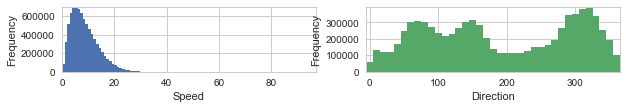

In [5]:
plot_speed_and_angle_distribution(df.speed, df.dir)

In [6]:
# Dir [10,360]=> [0,350]
df['dir'] = df['dir'].apply(lambda x: x%360 if x < 999 else x) 
df['month'] = df['date']%10000//100
# Convert Windrose coordianates to Polar Cooridinates 
df['dir_windrose'] = df['dir']
df['dir'] = df['dir'].apply(lambda x: (90 - x)%360 if x < 999 else x)
df.describe()

date          HrMn           vis           dir         speed  \
count  8.133497e+06  8.133497e+06  8.133497e+06  8.133497e+06  8.133497e+06   
mean   2.008338e+07  1.178535e+03  2.297928e-01  1.748657e+02  8.139556e+00   
std    4.858648e+04  6.918066e+02  1.079913e+00  1.069534e+02  5.195286e+00   
min    2.000010e+07  0.000000e+00 -1.000000e+00  0.000000e+00  0.000000e+00   
25%    2.004091e+07  6.000000e+02  6.400000e-02  9.500000e+01  4.000000e+00   
50%    2.008120e+07  1.159000e+03  8.400000e-02  1.580000e+02  7.000000e+00   
75%    2.012122e+07  1.758000e+03  1.320000e-01  2.830000e+02  1.100000e+01   
max    2.016123e+07  2.359000e+03  5.566000e+01  3.590000e+02  9.700000e+01   

              month  dir_windrose  
count  8.133497e+06  8.133497e+06  
mean   6.508310e+00  1.884830e+02  
std    3.453599e+00  1.055669e+02  
min    1.000000e+00  0.000000e+00  
25%    4.000000e+00  9.300000e+01  
50%    7.000000e+00  1.710000e+02  
75%    1.000000e+01  2.940000e+02  
max    1.200000e+01  3.590000e+02

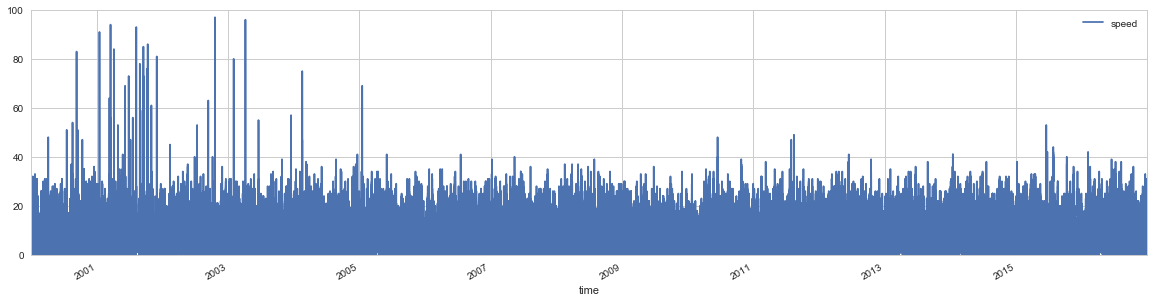

In [7]:
df.plot(x='time', y='speed',legend=True,figsize=(20,5))

### 1.2.1 Unit Detection

In [8]:
if 'knot_unit' not in globals():
    df['decimal'] = df.speed % 1
    df.decimal.hist(alpha=0.5, label='m/s', figsize=(4, 3))
    knot_unit = True if len(df.query('decimal >= 0.2')) / len(df) > 0.3 else False

    if knot_unit:
        df['speed'] = df['speed'] * 1.943845
        df['decimal'] = df.speed % 1
        df.decimal.hist(alpha=0.5, label='knot')
        # need more elaboration, some is not near an integer
        df['speed'] = df['speed'].apply(lambda x: int(round(x)))
    plt_configure(xlabel='Decimal', ylabel='Frequency', legend={'loc': 'best'}, title='Decimal Distribution')
    df.drop(['decimal'], 1,inplace=True)
print(knot_unit)

True


### 1.2.2 Sampling Type Selection

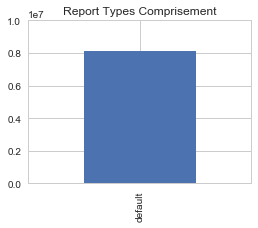

In [9]:
sample_type = df.query('date > 20000000')['type']
sample_type.value_counts().plot(
    kind = 'bar', title = 'Report Types Comprisement', figsize=(4,3))

report_type_most_used = sample_type.value_counts().argmax()
df = df.query("type==@report_type_most_used")

### 1.2.3 Sampling Time Selection

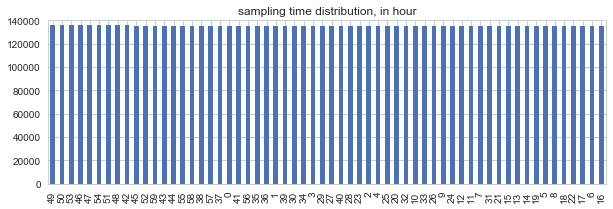

In [10]:
df['sample_time'] = df.HrMn % 100 
sample_time = df.query('date > 20000000')['sample_time']
sample_time.value_counts().plot(
    kind = 'bar', title = 'sampling time distribution, in hour', figsize=(10,3))

# Need more elaboration
sample_times = sample_time.value_counts()[sample_time.value_counts() > 2000]
sample_times = sample_times.index.tolist()
df = df.query("sample_time in @sample_times")
df.drop(['sample_time'], 1,inplace=True)

In [11]:
df['HrMn'].value_counts().sort_index()

0       5652
1       5655
2       5638
3       5635
4       5630
5       5636
6       5631
7       5635
8       5638
9       5650
10      5647
11      5632
12      5627
13      5627
14      5629
15      5637
16      5642
17      5652
18      5647
19      5649
20      5649
21      5652
22      5646
23      5640
24      5645
25      5659
26      5653
27      5652
28      5645
29      5642
        ... 
2330    5622
2331    5616
2332    5623
2333    5625
2334    5621
2335    5625
2336    5621
2337    5616
2338    5623
2339    5622
2340    5617
2341    5629
2342    5628
2343    5636
2344    5648
2345    5634
2346    5630
2347    5634
2348    5634
2349    5631
2350    5626
2351    5629
2352    5644
2353    5649
2354    5635
2355    5626
2356    5615
2357    5619
2358    5630
2359    5642
Name: HrMn, dtype: int64

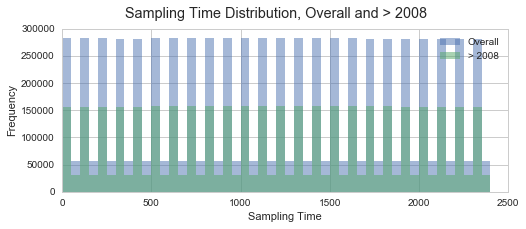

In [12]:
MID_YEAR = (min(df.date)//10000+max(df.date)//10000)//2
bins=arange(0, 2400+100, 50)

df['HrMn'].plot(kind='hist', alpha=0.5,bins=bins, label='Overall')

df.query('date > @MID_YEAR * 10000')['HrMn'].plot(
    kind='hist', alpha=0.5, bins=bins, label='> %s' %  MID_YEAR )

plt_configure(xlabel='Sampling Time', ylabel='Frequency', legend={'loc':'best'}, figsize=(8, 3), 
              title = 'Sampling Time Distribution, Overall and > %s ' %  MID_YEAR)

## 1.3 Data Wrangling

### 1.3.1 Artefacts

#### 1.3.1.1 wrong direction record

In [13]:
if integer_data:
    display(df.query("(dir % 10 >= 0.1) & (dir != 999)"))
    df = df.query('(dir % 10 <= 0.1) | (dir == 999)')

#### 1.3.1.2 sudden increase in speed

stationID      date  HrMn    vis day_type  dir  speed dir_max  \
1221016  24011KBIS  20021020  1018  0.150        D   81     97      11   
1417539  24011KBIS  20030407  1539  0.056        D   89     96       4   
570883   24011KBIS  20010318   358  0.106        N  340     94      10   
743155   24011KBIS  20010808  1014  0.134        D   82     93       9   
489438   24011KBIS  20010115  1400  0.878        D  142     91      10   
800968   24011KBIS  20011011   140  0.068        N   82     86       3   
771314   24011KBIS  20010916  2353  0.258        N   82     85       1   
594892   24011KBIS  20010405  1911  0.067        D  292     84       9   
324984   24011KBIS  20000910   416  0.057        N  240     83       3   
857110   24011KBIS  20011130   622  0.196        N   82     81       6   

        speed_max     type wind_type                time  month  dir_windrose  \
1221016        95  default   default 2002-10-20 10:18:00     10             9   
1417539       104  default   default 2003-04-07 15:39:00      4             1   
570883        122  default   default 2001-03-18 03:58:00      3           110   
743155         93  default   default 2001-08-08 10:14:00      8             8   
489438        312  default   default 2001-01-15 14:00:00      1           308   
800968         92  default   default 2001-10-11 01:40:00     10             8   
771314         81  default   default 2001-09-16 23:53:00      9             8   
594892        152  default   default 2001-04-05 19:11:00      4           158   
324984        236  default   default 2000-09-10 04:16:00      9           210   
857110         77  default   default 2001-11-30 06:22:00     11             8   

         incre  incre_reverse  
1221016   86.0           85.0  
1417539   91.0           93.0  
570883    85.0           85.0  
743155    85.0           84.0  
489438    81.0           82.0  
800968    83.0           83.0  
771314    84.0           84.0  
594892    76.0           75.0  
324984    76.0           80.0  
857110    76.0           76.0

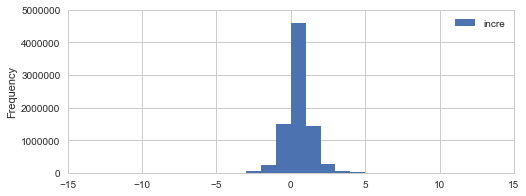

In [14]:
# sudden increse
df['incre'] = df.speed.diff(1)
df['incre'].fillna(0, inplace=True)
df['incre_reverse'] = df.speed.diff(-1)
df['incre_reverse'].fillna(0, inplace=True)

display(df.sort_values(by='speed',ascending=False).head(10))
df['incre'].plot(kind='hist', bins=arange(-15, 15), legend=True, figsize=(8, 3))

In [15]:
incre_threshold = 20 if knot_unit else 10
print('sudden increase number', len(df.query('(incre > @incre_threshold )&(incre_reverse > @incre_threshold )')))
df = df.query('(incre < @incre_threshold )|(incre_reverse < @incre_threshold )')

# Check the max speed
display(df.sort_values(by='speed',ascending=False).head(10))
df.drop(['incre', 'incre_reverse'], 1, inplace=True)

sudden increase number 43


stationID      date  HrMn     vis day_type  dir  speed dir_max  \
720938   24011KBIS  20010719  2234  12.030        N  232     56     214   
720937   24011KBIS  20010719  2233  13.990        N  231     55     223   
1501279  24011KBIS  20030619  1231   0.070        D  331     55     117   
1501280  24011KBIS  20030619  1232   0.069        D  329     54     113   
7368160  24011KBIS  20150619  2009  29.260        N  123     53     337   
7368159  24011KBIS  20150619  2008  30.000        N  126     52     332   
7368161  24011KBIS  20150619  2010  25.460        N  119     51     323   
7368162  24011KBIS  20150619  2011  20.310        N  116     51     334   
7368163  24011KBIS  20150619  2012  18.930        N  115     50     330   
5415661  24011KBIS  20110815  2011  29.410        N  178     49     274   

        speed_max     type wind_type                time  month  dir_windrose  \
720938         59  default   default 2001-07-19 22:34:00      7           218   
720937         65  default   default 2001-07-19 22:33:00      7           219   
1501279        76  default   default 2003-06-19 12:31:00      6           119   
1501280        76  default   default 2003-06-19 12:32:00      6           121   
7368160        62  default   default 2015-06-19 20:09:00      6           327   
7368159        69  default   default 2015-06-19 20:08:00      6           324   
7368161        61  default   default 2015-06-19 20:10:00      6           331   
7368162        64  default   default 2015-06-19 20:11:00      6           334   
7368163        57  default   default 2015-06-19 20:12:00      6           335   
5415661        57  default   default 2011-08-15 20:11:00      8           272   

         incre  incre_reverse  
720938     1.0            9.0  
720937    12.0           -1.0  
1501279   32.0            1.0  
1501280   -1.0           33.0  
7368160    1.0            2.0  
7368159    8.0           -1.0  
7368161   -2.0            0.0  
7368162    0.0            1.0  
7368163   -1.0            3.0  
5415661    1.0           10.0

### 1.3.2 0 Speed

In [16]:
with_too_many_zero, null_wind_frequency = is_with_too_many_zero(df.query("(date >= 20050000)"))
delete_zero = with_too_many_zero
if delete_zero:
    df = df.query('(speed > 0)')
print(delete_zero, null_wind_frequency)

False 0.0100447077557


### 1.3.3 Direction re-aligment and 999
For some dataset, the 16 sectors are not record properly,

e.g. the sectors are [0,20,30,50], need to redistribute the angle into 22.5

In [17]:
display(df['dir'].value_counts().sort_index())
effective_column = df.query('dir < 999')['dir'].value_counts()[df['dir'].value_counts() > 30].sort_index()
if integer_data:
    SECTOR_LENGTH = 360/len(effective_column) 
else: 
    SECTOR_LENGTH = 10
print(len(effective_column), SECTOR_LENGTH)

0      27091
1      27574
2      27554
3      28250
4      28556
5      28833
6      29423
7      29737
8      29911
9      30671
10     30223
11     30511
12     30112
13     30071
14     30473
15     30572
16     30726
17     30864
18     30744
19     30917
20     30960
21     30882
22     30789
23     31108
24     31132
25     31061
26     31249
27     31040
28     31147
29     31213
       ...  
330    23047
331    22577
332    22528
333    22243
334    22198
335    21962
336    22097
337    21687
338    21704
339    21702
340    21717
341    21548
342    21978
343    21834
344    22070
345    22090
346    22267
347    22798
348    23142
349    23072
350    23381
351    24103
352    24713
353    24698
354    25062
355    25349
356    25426
357    25946
358    26394
359    26856
Name: dir, dtype: int64

360 10


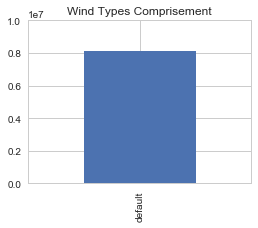

In [18]:
df=realign_direction(df, effective_column)
df=fill_direction_999(df, SECTOR_LENGTH)

### 1.3.4 Time Shift Comparison

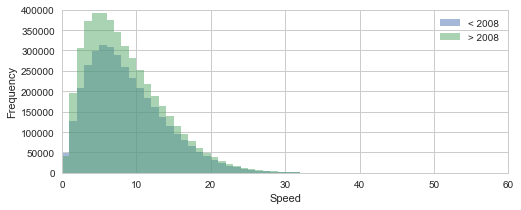

In [19]:
DIR_REDISTRIBUTE = 'even'
if DIR_REDISTRIBUTE == 'even':
    DIR_BIN = arange(-5, 360, 10) 
elif DIR_REDISTRIBUTE == 'round_up':
    DIR_BIN = arange(0, 360+10, 10) 

# Comparison between mid_year, looking for: 
# 1. Odd Even Bias
# 2. Time Shift of Wind Speed Distribution
bins = arange(0, max(df.speed) + 1)
df.query('date < @MID_YEAR * 10000')['speed'].plot(
    kind='hist', alpha=0.5,bins=bins, label='< %s' % MID_YEAR)

df.query('date > @MID_YEAR * 10000')['speed'].plot(
    kind='hist', alpha=0.5,bins=bins, label='> %s' % MID_YEAR)

plt.suptitle('Speed Comparison between year < %s, > %s ' % (MID_YEAR, MID_YEAR), fontsize = 14)
plt_configure(xlabel='Speed', ylabel='Frequency', legend=True, figsize=(8, 3))

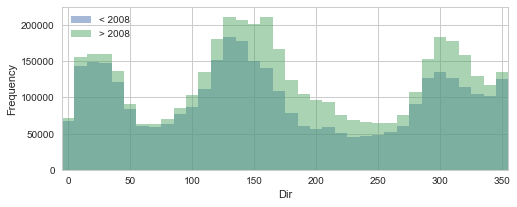

In [20]:
df.query('date < @MID_YEAR * 10000')['dir'].plot(
    kind='hist', alpha=0.5,bins=DIR_BIN, label='< %s' % MID_YEAR)

df.query('date > @MID_YEAR * 10000')['dir'].plot(
    kind='hist', alpha=0.5,bins=DIR_BIN, label='> %s' % MID_YEAR)

plt.suptitle('Dir Comparison between year < %s, and > %s ' % (MID_YEAR, MID_YEAR), fontsize = 14)
plt_configure(xlabel='Dir', ylabel='Frequency', legend={'loc':'best'}, figsize=(8, 3),tight='x')

2000 - 2004


D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


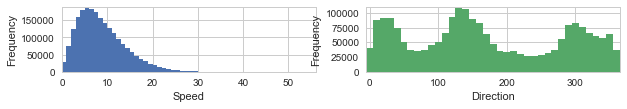

2005 - 2009


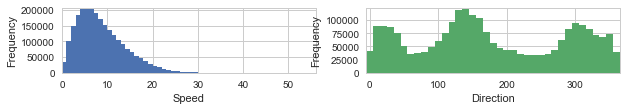

2010 - 2014


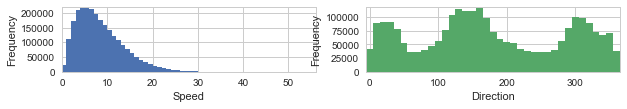

2015 - 2016


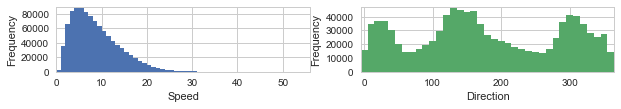

In [21]:
# Inspect the time shift of speed and degree distribution, and odd-even bias
check_time_shift(df)

## 1.4 Re-distribute Direction and Speed
e.g. Dir 50 -> -45 ~ 55, to make KDE result better

In [22]:
if integer_data:
    df = randomize_angle(df, DIR_REDISTRIBUTE, SECTOR_LENGTH)

In [23]:
if integer_data:
    if delete_zero:
        redistribute_method = 'down'
    else:
        redistribute_method = 'up'

    df, speed_redistribution_info = randomize_speed(df, redistribute_method)

## 1.5 Generate (x,y) from (speed,dir)

In [24]:
# Cook orientation
# df['dir']= (df['dir'] + 180)%360

In [25]:
# There might be a small dot in the centre, which is due to too many zero (more than 1 speed) in center
# Scatter plot in matplot has performance issue, the speed is very slow
df['x'] = df['speed'] * cos(df['dir'] * pi / 180.0)
df['y'] = df['speed'] * sin(df['dir'] * pi / 180.0)

# 2. Re-select Data and Configs

## 2.1 Data Overview

In [26]:
## Summery of the data selection
print('Knot unit?', knot_unit)
print('Report type used:', report_type_most_used)
print('Sampling time used:', sample_times)
if 'speed_redistribution_info' in globals():
    print('Speed redistribution info:', speed_redistribution_info )

df_all_years = df # for later across-year comparison
df = df_all_years.query('(date >= 20100000) & (date < 20150000)')
# df = df.query('(HrMn == 0) and (speed >= 0.5) and (date%10000 > 900) and (date%10000 < 1000)' )
df.describe()

Knot unit? True
Report type used: default
Sampling time used: [49, 50, 53, 46, 47, 54, 51, 48, 42, 45, 52, 59, 43, 44, 55, 58, 38, 57, 37, 0, 41, 56, 35, 36, 1, 39, 30, 34, 3, 29, 27, 40, 28, 23, 2, 4, 25, 20, 32, 10, 33, 26, 9, 24, 12, 11, 7, 31, 21, 15, 13, 14, 19, 5, 8, 18, 22, 17, 6, 16]


date          HrMn           vis           dir         speed  \
count  2.529192e+06  2.529192e+06  2.529192e+06  2.529192e+06  2.529192e+06   
mean   2.012076e+07  1.178396e+03  2.637254e-01  1.764880e+02  7.957047e+00   
std    1.414768e+04  6.917063e+02  1.283915e+00  1.056254e+02  5.151887e+00   
min    2.010010e+07  0.000000e+00 -1.000000e+00  0.000000e+00  0.000000e+00   
25%    2.011041e+07  5.590000e+02  6.000000e-02  1.000000e+02  4.000000e+00   
50%    2.012071e+07  1.159000e+03  8.000000e-02  1.620000e+02  7.000000e+00   
75%    2.013100e+07  1.758000e+03  1.360000e-01  2.820000e+02  1.100000e+01   
max    2.014123e+07  2.359000e+03  5.566000e+01  3.590000e+02  4.900000e+01   

              month  dir_windrose             x             y  
count  2.529192e+06  2.529192e+06  2.529192e+06  2.529192e+06  
mean   6.526445e+00  1.908024e+02 -4.911318e-01  1.038588e+00  
std    3.455653e+00  1.044558e+02  6.767466e+00  6.537438e+00  
min    1.000000e+00  0.000000e+00 -4.897015e+01 -4.238148e+01  
25%    4.000000e+00  9.700000e+01 -4.773989e+00 -2.395907e+00  
50%    7.000000e+00  1.780000e+02 -0.000000e+00  7.492132e-01  
75%    1.000000e+01  2.920000e+02  4.000000e+00  4.662876e+00  
max    1.200000e+01  3.590000e+02  3.199513e+01  3.654182e+01

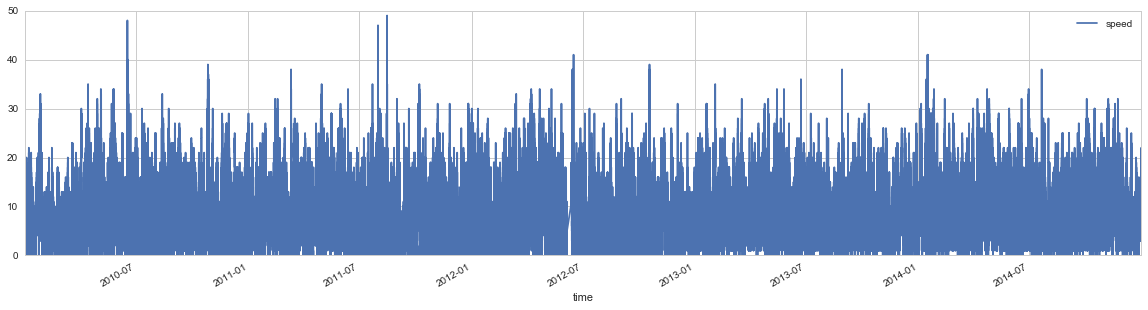

In [27]:
df.plot(x='time', y='speed',legend=True,figsize=(20,5))

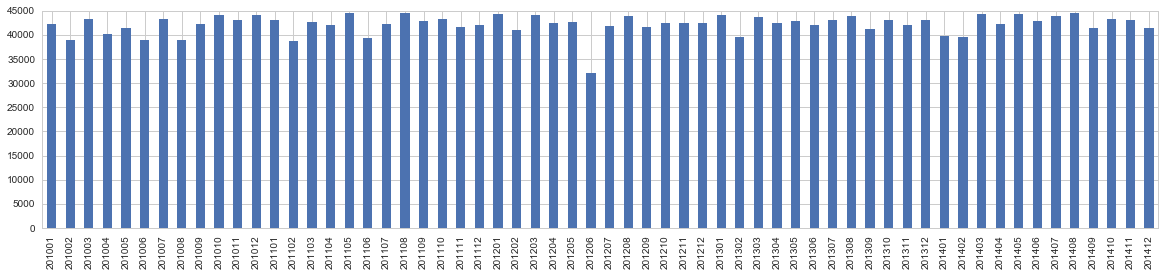

In [28]:
df['date'].apply(lambda x: str(x)[:-2]).value_counts().sort_index().plot(kind='bar', figsize=(20,4))

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


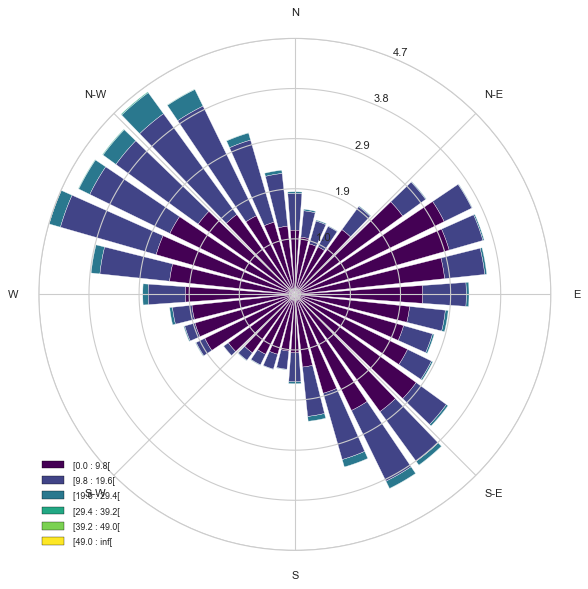

In [29]:
# 90 degree is east
ax = WindroseAxes.from_ax()
viridis = plt.get_cmap('viridis')
ax.bar(df.dir_windrose, df.speed, normed=True, opening=0.8, edgecolor='white', nsector=36, cmap=viridis)
ax.set_legend()

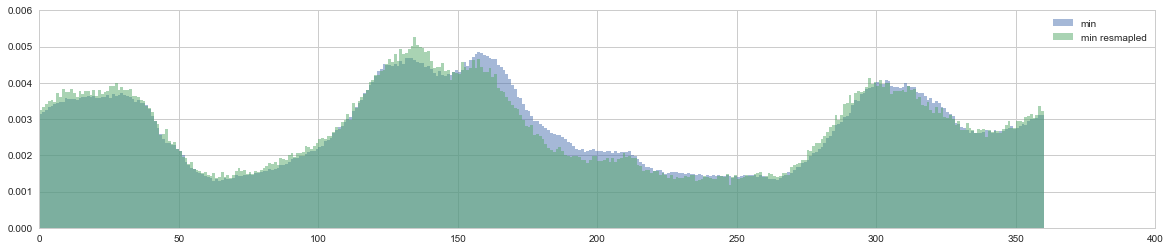

In [ ]:
if len(df) > 1000000:
    bins=arange(0,362)
    df['dir'].hist(bins=bins, normed=True,alpha=0.5,label='min')
    
    df = df_all_years.sample(n=500000, replace=True)    
    df['dir'].hist(bins=bins, normed=True,alpha=0.5,label='min resmapled')
    plt_configure(legend=True, figsize=(20,4))

In [ ]:
ax, _params = WindAxes.from_ax().pdf(df.speed, bins=arange(0, df.speed.max()))
plt_configure(figsize=(4,3),xlabel='V',ylabel='PDF')

fig,ax = plt.subplots()
ecdf = sm.distributions.ECDF(df.speed)
x = linspace(0, df.speed.max())
y = ecdf(x)
plot(log(x), log(-log(1-y)),'o', label='ECDF')

k_shape, _, lamb_scale = sp.stats.weibull_min.fit(df.speed, loc=0)
y=1-exp(-(x/lamb_scale)**k_shape) # cdf
plot(log(x), log(-log(1-y)),'-', label='Weibull')
plt_configure(xlabel="ln(V)", ylabel="ln(-ln(1-P)",legend={'loc':'best'},figsize=(4,3))
align_figures()
print(k_shape, lamb_scale)

In [ ]:
df.plot(kind='scatter', x='x', y='y', alpha=0.10, s=2)
plt.gca().set_aspect('equal')

## 2.2. Overview by Direction

In [ ]:
if len(effective_column) == 16:
    rebinned_angle = 22.5
else: 
    rebinned_angle = 10

In [ ]:
original_incre, incre = SECTOR_LENGTH, rebinned_angle
start, end = -original_incre/2 + incre/2, 360

max_speed = df.speed.max()
max_count = max_count_for_angles(df, start, end, incre)
plot_range = [0, max_speed, 0, max_count*1.05]

for angle in arange(start, end, incre):
    start_angle, end_angle = angle-incre/2, angle+incre/2
    sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)   
    
    fig = plt.figure()
    title ='%s (%s - %s), %s' % (angle, start_angle, end_angle, len(sub_df)) 
    sub_df['speed'].hist(bins=arange(0, max_speed), alpha=0.5, label='Data')
    plt.axis(plot_range)
    plt_configure(figsize=(3,1.5), title=title)
align_figures()

## 2.3 Overview by Month

In [ ]:
month_incre = 1
current_df = df.query('speed>=1')
for month in arange(1, 12+month_incre, month_incre): 
    end_month = month+month_incre
    sub_df = current_df.query('(month >= @month) and (month < @end_month)')
    if len(sub_df) > 0:
        if month_incre == 1:
            title = 'Month: %s' % (month)
        else:
            title = 'Month: %s - %s ' % (month, end_month-1)
        ax = WindroseAxes.from_ax()
        ax.bar(sub_df.dir_windrose, sub_df.speed, normed=True, opening=0.8, edgecolor='white', nsector=36, cmap=plt.get_cmap('viridis'))
        plt_configure(figsize=(3,3), title=title)
align_figures()

## 2.4 Create input data, i.e. speed_set

In [ ]:
SPEED_SET = array(list(zip(df.x, df.y)))
NUMBER_OF_GAUSSIAN = 3
FIT_METHOD = 'square_error'
DEFAULT_BANDWDITH = 1.5 if knot_unit else 0.7
fig_list = []

In [ ]:
fit_limit = ceil(df['speed'].quantile(.95))
fitting_axis_range = arange(-fit_limit, fit_limit+1, 1)
print(fitting_axis_range)

FITTING_RANGE = []
for i in fitting_axis_range:
    for j in fitting_axis_range:
        FITTING_RANGE.append([i,j])

In [ ]:
plot_limit = ceil(df['speed'].quantile(.95))
PLOT_AXIS_RANGE = arange(-plot_limit, plot_limit+1, 1)

# 3. Kernel Density Estimation

In [ ]:
sample = SPEED_SET
KDE_KERNEL = 'gaussian'
# KDE_KERNEL, bandwidth = 'tophat', 1

In [ ]:
%%time
from sklearn.grid_search import GridSearchCV
# from sklearn.model_selection import GridSearchCV  ## too slow

# The bandwidth value sometimes would be too radical
if knot_unit:
    bandwidth_range = arange(0.7,2,0.2)
else:
    bandwidth_range = arange(0.4,1,0.1)

# Grid search is unable to deal with too many data (a long time is needed)
if len(sample) > 50000:    
    df_resample=df.sample(n=50000, replace=True)
    bandwidth_search_sample = array(list(zip(df_resample.x, df_resample.y)))
else:
    bandwidth_search_sample = sample

grid = GridSearchCV(neighbors.KernelDensity(kernel = KDE_KERNEL),
                    {'bandwidth': bandwidth_range}, n_jobs=-1, cv=4) 

grid.fit(bandwidth_search_sample)
bandwidth = grid.best_params_['bandwidth']
print(bandwidth)

In [ ]:
if 'bandwidth' not in globals():
    bandwidth = DEFAULT_BANDWDITH

kde = neighbors.KernelDensity(bandwidth=bandwidth,kernel = KDE_KERNEL).fit(sample)

points = FITTING_RANGE
# very slow if the dataset is too large, e.g. 100,000
# kde returns log prob, need to convert it
kde_result = exp(kde.score_samples(points))
print('bandwidth:', bandwidth, len(kde_result))
print(kde_result[:5])

In [ ]:
# Plot jPDF
X = Y = PLOT_AXIS_RANGE
# Can't work if pass as generate_Z_from_X_Y(X,Y, exp(kde.score_samples())), need to use lambda
# see http://stackoverflow.com/questions/21035437/passing-a-function-as-an-argument-in-python
kde_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(kde.score_samples(coords)))
colorbar_lim = 0, kde_Z.max()

plot_3d_prob_density(X,Y,kde_Z)

fig_kde,ax1 = plt.subplots(figsize=(4,3))
plot_2d_prob_density(X,Y,kde_Z,xlabel='x', ylabel='y',ax=ax1)

with sns.axes_style({'axes.grid' : False}):
    from matplotlib import ticker
    fig_hist,ax2 = plt.subplots(figsize=(4,3))
    _,_,_,image = ax2.hist2d(df.x, df.y, bins=PLOT_AXIS_RANGE, cmap='viridis',)
    ax2.set_aspect('equal')
    cb = plt.colorbar(image)
    tick_locator = ticker.MaxNLocator(nbins=6)
    cb.locator = tick_locator
    cb.update_ticks()
    plt_configure(ax=ax2, xlabel='x',ylabel='y')
align_figures()

In [ ]:
kde_cdf = cdf_from_pdf(kde_result)

# 4. GMM by Expectation-maximization

In [ ]:
sample= SPEED_SET
clf = mixture.GaussianMixture(n_components=NUMBER_OF_GAUSSIAN, covariance_type='full')
clf.fit(sample)
print(clf.converged_)

In [ ]:
gmm_em_result = read_gmm_em_result(clf)
pretty_print_gmm(gmm_em_result)

In [ ]:
fig,ax = plt.subplots(figsize=(3.5,3.5))
plot_gmm_ellipses(gmm_em_result, ax=ax)

In [ ]:
X = Y = PLOT_AXIS_RANGE
pdf_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(clf.score_samples(coords)))

def residule_between_kde_and_gmm(points):
    kde_vals = exp(kde.score_samples(points))
    gmm_vals = exp(clf.score_samples(points))
    return kde_vals - gmm_vals 

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

plot_3d_prob_density(X,Y,pdf_Z)
plot_3d_prob_density(X,Y,residual_Z)
align_figures()

fig = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,kde_Z,xlabel='x',ylabel='y', colorbar_lim=colorbar_lim)
fig_em = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,pdf_Z,xlabel='x',ylabel='y', colorbar_lim=colorbar_lim)
fig = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,residual_Z,xlabel='x',ylabel='y')
align_figures()

## Goodness-of-fit Statistics

In [ ]:
points = FITTING_RANGE
gmm_pdf_result = exp(clf.score_samples(points))
gof_df(gmm_pdf_result, kde_result)

# 5. GMM by Optimization

In [ ]:
sample = SPEED_SET
points = FITTING_RANGE
max_speed = df.speed.max()
print(FIT_METHOD)

In [ ]:
# from GMM,EM 
# GMM format: weight, meanx, meany, sigx, sigy, rho
x0 = gmm_em_result

cons = [
        # sum of every 6th element, which is the fraction of each gaussian
        {'type': 'eq', 'fun': lambda x: sum(x[::6]) - 1},
        # # limit the width/height ratio of elliplse, optional
#         {'type': 'ineq', 'fun': lambda x: width_height_ratios_set(x) - 1/3},
#         {'type': 'ineq', 'fun': lambda x: 3 - width_height_ratios_set(x)},
]

bonds = [(0., 0.99),(-fit_limit, fit_limit),(-fit_limit, fit_limit),
         (0., fit_limit),(0., fit_limit),(-0.99, 0.99)]*(len(x0)//6)

result = sp.optimize.minimize(
    lambda x0: GMM_fit_score(x0, kde_result, points, FIT_METHOD),
    x0,
    bounds = bonds,
    constraints=cons,
    tol = 0.000000000001,
    options = {"maxiter": 500})
result

## 5.1 GMM Result

In [ ]:
gmm = group_gmm_param_from_gmm_param_array(result.x, sort_group = True)
mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
gmm_pdf_result = mixed_model_pdf(points)
pretty_print_gmm(gmm)

In [ ]:
fig_gmm, ax = plt.subplots(figsize=(3.5,3.5))
plot_gmm_ellipses(gmm,ax=ax)

## 5.2 Goodness-of-fit statistics

In [ ]:
gof_df(gmm_pdf_result, kde_result)

In [ ]:
X = Y = PLOT_AXIS_RANGE
pdf_Z = generate_Z_from_X_Y(X,Y, mixed_model_pdf)# passing a function as an argument

def residule_between_kde_and_gmm(points):
    kde_vals = exp(kde.score_samples(points))
    gmm_vals = mixed_model_pdf(points)
    return kde_vals - gmm_vals 

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

plot_3d_prob_density(X,Y,pdf_Z)
plot_3d_prob_density(X,Y,residual_Z)
align_figures()

fig = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,kde_Z,xlabel='x',ylabel='y')
fig_gmm = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,pdf_Z,xlabel='x',ylabel='y')
fig = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,residual_Z,xlabel='x',ylabel='y')
align_figures()

In [ ]:
def f(V,theta):
    return (mixed_model_pdf([[V*cos(theta),V*sin(theta)]]))*V

In [ ]:
x = linspace(0, max_speed, 15)

# 1. Plot v-p points, empirical distribution
ecdf = sm.distributions.ECDF(df.speed)
y = ecdf(x)
plot(log(x), log(-log(1-y)),'o', label = 'Empirical')

# 2. Weibull distribution
weibull_params = sp.stats.weibull_min.fit(df.speed, loc=0)
y_cdf_weibull = sp.stats.weibull_min.cdf(x, *weibull_params)
plot(log(x), log(-log(1-y_cdf_weibull)),'--', label = 'Weibull')

# 3. GMM distribution
y_ = [integrate.nquad(f, [[0, x_val],[0, 2*pi]]) for x_val in x]
y = array(list(zip(*y_))[0])
plot(log(x), log(-log(1-y)),'-', color='black', label = 'GMM')

plt_configure(xlabel='ln(V)',ylabel='ln(-ln(1-P))',legend={'loc':'best'})

In [ ]:
# Calculate Angle Distribution
x = linspace(0,2*pi, num=36+1)
y_ =[integrate.nquad(f, [[0, inf],[x_-pi/36, x_+pi/36]]) for x_ in x]
y = array(list(zip(*y_))[0])*len(df['dir']) 

df['dir'].hist(bins=DIR_BIN, alpha=0.5, label='Data')
plot(x/pi*180, y,'-', color='black', label='GMM')
title='Direction Distribution Comparison'
plt_configure(xlabel='Direction',ylabel='Frequency', 
              legend={'loc': 'best'} ,tight='xtight',figsize = (4.5,2))
dir_fig = plt.gcf()
print(title)

In [ ]:
# Calculate Speed Distribution
# 1. GMM Model
x = arange(0, max_speed, 0.5)
y_ =[integrate.nquad(f, [[x_-0.01, x_+0.01],[0, 2*pi]]) for x_ in x]
y = array(list(zip(*y_))[0])*len(df.speed)/0.02
plot(x, y,'-', color='black', label='GMM')

# 2. Observation
df['speed'].hist(bins=arange(0, df.speed.max()), alpha=0.5, label='Data')

# 3. Weibull
y_weibul = sp.stats.weibull_min.pdf(x, *weibull_params)* len(df.speed)
plot(x, y_weibul, '--', color='black', label='Weibull')   

title='Speed Distribution Comparison'
plt_configure(xlabel='Speed',ylabel='Frequency',legend=True, figsize=(4.5, 2))
plt.gca().set_ylim(bottom = 0)
plt.locator_params(axis='y', nbins=5)
print(title)

In [ ]:
# %%time
incre = max(SECTOR_LENGTH, 10)
density_collection=Parallel(n_jobs=-1)(delayed(direction_compare)(gmm, df, angle, incre) 
                                        for angle in arange(0, 360, incre))  
# This R square is computed as in paper 
# Comparison of bivariate distribution constructionapproaches for analysing wind speed anddirection data
# http://onlinelibrary.wiley.com/doi/10.1002/we.400/full
print(true_R_square(density_collection))

## 5.3 Sectoral Comaprison

In [ ]:
# Calculate Speed Distribution
def model_data_comparison(df, original_incre = 10, incre = 10):
    start, end = -original_incre/2 + incre/2, 360
    max_diff_array = []
    curve_collection = []
    max_speed = df.speed.max()
    
    # Find a max count for plotting histogram
    max_count = max_count_for_angles(df, start, end, incre)
    plot_range = [0, max_speed, 0, max_count*1.05]
    
    for angle in arange(start, end, incre):
        angle_radian, incre_radian = radians(angle), radians(incre)  
        start_angle, end_angle = angle-incre/2, angle+incre/2
        
        # Select data from observation
        sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)
        data_size = len(sub_df.speed)
        direction_prob = integrate.nquad(f, [[0, inf],
                                             [angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
        weibull_params = sp.stats.weibull_min.fit(sub_df.speed, loc=0)
        
        fig = plt.figure(figsize=(13,1.3))
        x = linspace(0, sub_max_speed, 20)
        # 1. Frequency Comparison
        ax1 = fig.add_subplot(1,3,1)        
        # 1.1. Data Histogram
        sub_df['speed'].hist(bins=arange(0, sub_max_speed), alpha=0.5, label='Data')             
        # 1.2. Model Distribution
        y_gmm_ =[integrate.nquad(f, [[x_-0.01, x_+0.01], 
                                     [angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
                                 for x_ in x]
        y_gmm = array(list(zip(*y_gmm_))[0])/direction_prob[0]/0.02
        plot(x, y_gmm*data_size,'-', color='black', label='GMM')
        # 1.3 Weibull Distribution
        y_weibull = sp.stats.weibull_min.pdf(x, *weibull_params)
        plot(x, y_weibull*data_size, '--', color='black',label='Weibull')   
        plt_configure(xlabel = "V", ylabel='Frequency', legend=True)
        plt.axis(plot_range)
        
        # 2. CDF Comaprison
        ax2 = fig.add_subplot(1,3,2)
        # 2.1. Empirical distribution
        ecdf = sm.distributions.ECDF(sub_df.speed)
        y_ecdf = ecdf(x)
        # 2.2. Model
        y_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
             for x_val in x]
        y_cdf_gmm = array(list(zip(*y_))[0])/direction_prob[0]
        # 2.3 Weibull
        y_cdf_weibull = sp.stats.weibull_min.cdf(x, *weibull_params)      
        plot(x, y_ecdf,'o', alpha=0.8, label='Data')
        plot(x, y_cdf_gmm,'-', color='black',label='GMM')
        plot(x, y_cdf_weibull,'--', color='black',label='Weibull')
        plt.gca().set_xlim(right = max_speed)
        plt_configure(xlabel = "V", ylabel='P', legend=True)
        
        # 3. Weibull Comparison
        ax3 = fig.add_subplot(1,3,3)
        plot(log(x), log(-log(1-y_ecdf)),'o', alpha=0.8, label='Data')
        plot(log(x), log(-log(1-y_cdf_gmm)),'-', color='black', label='GMM')
        plot(log(x), log(-log(1-y_cdf_weibull)),'--',color='black',label='Weibull')
        plt_configure(xlabel="ln(V)", ylabel="ln(-ln(1-P)",legend={'loc':'best'})
        plt.gca().set_xlim(right = log(max_speed+1))
        
        print('%s (%s - %s) degree' % (angle, start_angle, end_angle)     )

        bins = arange(0, sub_df.speed.max()+1)
        density, _ = np.histogram(sub_df['speed'],bins=bins, normed=True)
        density_expected_ =[integrate.nquad(f, [[x_, x_+1],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
                    for x_ in bins[:-1]]
        density_expected_gmm = array(list(zip(*density_expected_ ))[0])/direction_prob[0]
        R_square_gmm = sector_r_square(density, density_expected_gmm)
        
        density_expected_weibull = sp.stats.weibull_min.cdf(bins[1:], *weibull_params) - sp.stats.weibull_min.cdf(bins[:-1], *weibull_params) 
        R_square_weibull = sector_r_square(density, density_expected_weibull)

        diff, diff_weibull= np.abs(y_ecdf - y_cdf_gmm), np.abs(y_ecdf - y_cdf_weibull)
        max_diff_array.append([len(sub_df), angle, diff.max(), x[diff.argmax()], 
                               diff_weibull.max(), x[diff_weibull.argmax()], R_square_gmm, R_square_weibull])
        curves = {'angle': angle, 'data_size': data_size, 'weight': direction_prob[0], 
                  'x': x, 'gmm_pdf': y_gmm, 'gmm_cdf': y_cdf_gmm,
                  'weibull_pdf': y_weibull, 'weibull_cdf': y_cdf_weibull, 'ecdf': y_ecdf}
        curve_collection.append(curves)
        
        plt.show()
        print('data size:', len(sub_df), 'weight', len(sub_df)/len(df))
        print('GMM', 'Weibull')
        print('R square', R_square_gmm,  R_square_weibull)
        print('max diff:', diff.max(), diff_weibull.max(), 'speed value:', x[diff.argmax()], 'y gmm', y_cdf_gmm[diff.argmax()])
        print(' ')
    return max_diff_array, curve_collection

In [ ]:
%%time
if len(effective_column) == 16:
    rebinned_angle = 22.5
else: 
    rebinned_angle = 20
max_diff_array, curve_collection = model_data_comparison(df, SECTOR_LENGTH, rebinned_angle)

In [ ]:
diff_df = pd.DataFrame(max_diff_array,columns=['datasize','direction', 'gmm', 'speed_gmm',
                                               'weibull', 'speed_weibull', 'r_square_gmm', 'r_square_weibull'])  

gmm_mean, weibull_mean = plot_sectoral_comparison(diff_df.r_square_gmm, diff_df.r_square_weibull, diff_df.direction, diff_df.datasize)
plt_configure(ylabel="$\ R^2$")
ylim = min(plt.gca().get_ylim()[0],0.85)
plt.gca().set_ylim(top=1, bottom=ylim)
print(gmm_mean, weibull_mean)

In [ ]:
gmm_mean, weibull_mean = plot_sectoral_comparison(diff_df.gmm, diff_df.weibull, diff_df.direction, diff_df.datasize)
plt_configure(ylabel="K-S")
ylim = max(plt.gca().get_ylim()[1],0.15)
plt.gca().set_ylim(top=ylim, bottom=0)
print(gmm_mean, weibull_mean)

In [ ]:
# Compare direction weight with previous figure
display(dir_fig)

### 5.3.1 Data Variability, by Bootstrap (Resampling)

In [ ]:
max_diff_element = max(max_diff_array, key=lambda x: x[2])
angle =  max_diff_angle = max_diff_element[1]
incre = rebinned_angle

In [ ]:
FRACTION = 1

# Select data from observation
start_angle, end_angle = angle-incre/2, angle+incre/2
angle_radian, incre_radian = radians(angle), radians(incre)  
sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)
weibull_params = sp.stats.weibull_min.fit(sub_df.speed, loc=0)

In [ ]:
fig = plt.figure(figsize=(13,1.5))
ax1 = fig.add_subplot(1,3,1)   
ax2 = fig.add_subplot(1,3,2)   
ax3 = fig.add_subplot(1,3,3)   

x = arange(0, sub_max_speed, 0.5)

# 1. Data
bins=arange(0, sub_max_speed)
sub_df['speed'].hist(ax=ax1, bins=bins, alpha=0.5, label='Data', normed=True)  

# 2. GMM
y_gmm_ =[integrate.nquad(f, [[x_-0.01, x_+0.01], [angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
          for x_ in x]
direction_prob = integrate.nquad(f, [[0, inf], [angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_gmm = array(list(zip(*y_gmm_))[0])/direction_prob[0]/0.02  
y_gmm_cdf_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) for x_val in x]
y_gmm_cdf = array(list(zip(*y_gmm_cdf_))[0])/direction_prob[0]
ax1.plot(x, y_gmm,'-', color='black', label='GMM')
ax2.plot(x, y_gmm_cdf,'-', color = 'black', label='GMM')
ax3.plot(log(x), log(-log(1-y_gmm_cdf)),'-', color = 'black',label='GMM')

# 3. Weilbull 
y_weibull = sp.stats.weibull_min.pdf(x, *weibull_params)
y_weibull_cdf = sp.stats.weibull_min.cdf(x, *weibull_params)
ax1.plot(x, y_weibull,'--',color='black',label='Weibull')
ax2.plot(x, y_weibull_cdf,'--',label='Weibull')
ax3.plot(log(x), log(-log(1-y_weibull_cdf)),'--',label='Weibull')

# 4. Data Resampled
count_collection = []
for i in range(1,100):
    sub_df_resampled = sub_df.sample(frac=FRACTION, replace=True)    
    resampled_count, _ = np.histogram(sub_df_resampled['speed'], bins=bins, normed=True) 
    count_collection.append(resampled_count)
    
    ecdf = sm.distributions.ECDF(sub_df_resampled.speed)
    y_ecdf = ecdf(x) 
    ax2.plot(x, y_ecdf,':', label='Data Resampled')
    ax3.plot(log(x), log(-log(1-y_ecdf)),':', label='Data Resampled')
    if i == 1: 
        plt_configure(ax=ax2, xlabel='V',ylabel='P',legend={'loc':'best'})
        plt_configure(ax=ax3, xlabel='V',ylabel='ln(-ln(1-P)',legend={'loc':'best'})

print('%s (%s - %s) Degree Speed Distribution' % (angle, start_angle, end_angle))
count_collection = np.array(count_collection)
mx, mn = np.max(count_collection,0), np.min(count_collection,0)
ax1.plot(bins[1:]-0.5, mx, ':', color='blue')
ax1.plot(bins[1:]-0.5, mn, ':', color='blue', label='Resample limit')
ax1.set_ylim(bottom = 0)
plt_configure(ax=ax1, xlabel='V',ylabel='Frequency',legend={'loc':'best'})
ax1.locator_params(axis='y', nbins=5)
ax2.locator_params(axis='y', nbins=5)
ax3.locator_params(axis='y', nbins=5)

diff = abs(y_ecdf - y_gmm_cdf)
print(diff.max(), x[diff.argmax()], y_gmm_cdf[diff.argmax()])

### 5.3.2 Time Variability

In [ ]:
fig_time_variability_3d = plt.figure()
ax1 = fig_time_variability_3d.gca(projection='3d')

fig_time_variability_cdf,ax2 = plt.subplots(figsize=(3,1.8))
fig_time_variability_weibull, ax3 = plt.subplots(figsize=(3,1.8))
 
x = arange(0, sub_max_speed, 0.5)

# 1. GMM
direction_prob = integrate.nquad(f, [[0, inf], [angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_gmm_ =[integrate.nquad(f, [[x_-0.01, x_+0.01], [angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
          for x_ in x]
y_gmm = array(list(zip(*y_gmm_))[0])/direction_prob[0]/0.02
y_gmm_cdf_ =[integrate.nquad(f, [[0, x_val],
                         [angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) for x_val in x]
y_gmm_cdf = array(list(zip(*y_gmm_cdf_))[0])/direction_prob[0]

ax2.plot(x, y_gmm_cdf,'-', color='black', label = 'GMM')
ax3.plot(log(x), log(-log(1-y_gmm_cdf)),'-', color='black',label='GMM')

# 2. Weibull
y_weibull = weibull_min.pdf(x, *weibull_params)
y_weibull_cdf = weibull_min.cdf(x, *weibull_params)
ax2.plot(x, y_weibull_cdf,'--', label='Weibull')
ax3.plot(log(x), log(-log(1-y_weibull_cdf)), '--', label='Weibull')

# 3. Data
prop_cycle=iter(mpl.rcParams['axes.color_cycle'])
for start_time in range(20000000, 20150000, 50000):
    end_time = start_time + 50000 
    time_label = start_time//10000
    df_other_years = df_all_years.query('(date >= @start_time) & (date < @end_time)')
    df_other_years_at_angle, sub_max_speed_other_year = select_df_by_angle(df_other_years, start_angle, end_angle)
    if len(df_other_years_at_angle) > 0 :
        
        ecdf = sm.distributions.ECDF(df_other_years_at_angle.speed)
        y_ecdf = ecdf(x)
        ax2.plot(x, y_ecdf,':', label = time_label)
        ax3.plot(log(x), log(-log(1-y_ecdf)),':', label = time_label)
        
        title = '%s - %s' %(time_label, time_label+4)
        count, division = np.histogram(df_other_years_at_angle['speed'], normed=True,
                                       bins=arange(0, sub_max_speed_other_year))
        ax1.bar(left=division[:-1], height=count, zs=time_label, zdir='x', 
                color=next(prop_cycle), alpha=0.8)
        x_3d = time_label*np.ones_like(x)
        ax1.plot(x_3d, x, y_gmm, '-', color='black', label='GMM'  if time_label == 2010 else '')
        ax1.plot(x_3d, x, y_weibull, '--', color='blue', label='Weibull' if time_label == 2010 else '')
        
print('%s (%s - %s) Degree Speed Distribution' % (angle, start_angle, end_angle))
ax1.set_ylim(bottom = 0)
ax1.set_zlabel('Frequency')
plt_configure(ax=ax1, xlabel='Time',ylabel='V', legend=True)
plt_configure(ax=ax2, xlabel='V',ylabel='P',legend={'loc':'best'})
plt_configure(ax=ax3, xlabel="ln(V)", ylabel="ln(-ln(1-P)",legend={'loc':'best'})
ax1.set_zlim(bottom = 0)
align_figures()

### 5.3.3 Adjacent Sector Variability

In [ ]:
incre = rebinned_angle
angle_group = [max_diff_angle-incre, max_diff_angle, max_diff_angle+incre]

In [ ]:
fig_adjecent_variability_3d = plt.figure()
ax1 = fig_adjecent_variability_3d.gca(projection='3d')
fig_adjecent_variability_cdf, ax2 = plt.subplots(figsize=(3,1.8))
fig_adjecent_variability_weibull, ax3 = plt.subplots(figsize=(3,1.8))

legend_3d = False
prop_cycle=iter(mpl.rcParams['axes.color_cycle'])

curve_df = pd.DataFrame(curve_collection)

for angle in angle_group:
    curves = curve_df.query('angle == @angle%360').T.to_dict()
    curves = curves[list(curves)[0]]
    data_size, x =  curves['data_size'], curves['x']
    y_gmm, y_cdf_gmm =  curves['gmm_pdf'], curves['gmm_cdf'] 
    y_weibull, y_cdf_weibull, y_cdf = curves['weibull_pdf'],  curves['weibull_cdf'], curves['ecdf']

    linestyle = '-' if angle == max_diff_angle else ':'
    alpha = 0.7 if angle == max_diff_angle else 0.3

    ax2.plot(x, y_gmm*data_size, linestyle, label=angle)        
    ax3.plot(x, y_weibull*data_size, linestyle, label=angle)

    start_angle, end_angle = angle-incre/2, angle+incre/2
    sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)

    x_3d = angle*np.ones_like(x)
    ax1.plot(x_3d, x, y_gmm*data_size, color='black', label='GMM')
    ax1.plot(x_3d, x, y_weibull*data_size, color='blue', linestyle='--',label='Weibull')

    count, division = np.histogram(sub_df['speed'], bins=arange(0, sub_max_speed))
    ax1.bar(left=division[:-1], height=count, zs=angle, zdir='x', color=next(prop_cycle), alpha=0.8)

    if legend_3d == False:
        ax1.legend()
        legend_3d = True
        
plt_configure(ax=ax1, xlabel='Direction', ylabel='Speed')   
plt_configure(ax=ax2, xlabel='V',ylabel='Frequency',legend={'loc':'best'})
plt_configure(ax=ax3, xlabel='V',ylabel='Frequency',legend={'loc':'best'})
ax1.set_zlabel('Frequency')
ax1.set_zlim(bottom = 0)
ylim = max(ax1.get_ylim()[1],ax3.get_ylim()[1])
ax2.set_ylim(bottom = 0, top=ylim)
ax3.set_ylim(bottom = 0, top=ylim)

print(max_diff_angle) 
print('GMM, Weibull, Histogram')
align_figures()

# 6. Result Variability & Cross-Validation

In [ ]:
if 'bandwidth' not in globals():
    bandwidth = DEFAULT_BANDWDITH    
if 'FIT_METHOD' not in globals():
    FIT_METHOD = 'square_error'       
if 'KDE_KERNEL' not in globals():
    KDE_KERNEL = 'gaussian'
    
config = {'bandwidth': bandwidth, 
          'fitting_range': FITTING_RANGE,
          'fit_limit': fit_limit,
          'kde_kernel': KDE_KERNEL}

## 6.1 Variability of the Result

In [ ]:
%%time
results = Parallel(n_jobs=-1)(delayed(resampled_fitting)(df, FIT_METHOD, NUMBER_OF_GAUSSIAN, config) for i in range(10))                        
for result in results:
    display(pretty_print_gmm(result['gmm']))
    fig,ax = plt.subplots(figsize=(3.5,3.5))
    plot_gmm_ellipses(result['gmm'],ax=ax)
    plt.show()
    
    display(gof_df(result['gmm_pdf_result'], result['kde_result']))
    display(gof_df(result['gmm_pdf_result'], kde_result))
    print('')

## 6.2 Cross-validation, to select the number of Gaussian

In [ ]:
%%time
from sklearn.cross_validation import train_test_split, KFold

## 5-fold cross validation
gaussian_number_range = arange(1,6)
CV_result_train_all,CV_result_test_all =[],[]
number_of_fold = 4
print('Number of train/test dataset', len(df)*(number_of_fold-1)/number_of_fold, len(df)/number_of_fold) 

for number_of_gaussian in gaussian_number_range:
    print( '  ')
    print('Number of gaussian', number_of_gaussian)
    
    kf = KFold(len(df), n_folds=number_of_fold, shuffle=True) 

    CV_result = Parallel(n_jobs=-1)(delayed(fit_per_fold)(df, train_index, test_index, FIT_METHOD, number_of_gaussian, config) for train_index, test_index in kf)                        

    CV_result_train, CV_result_test = list(zip(*CV_result))
    CV_result_train, CV_result_test = list(CV_result_train), list(CV_result_test)
        
    CV_result_train_all.append(CV_result_train)
    CV_result_test_all.append(CV_result_test)
    
    print('Train')
    pretty_pd_display(CV_result_train)
    print('Test')
    pretty_pd_display(CV_result_test)

In [ ]:
train_scores_mean, train_scores_std = generate_mean_std_gof(CV_result_train_all)
print('Train gof mean, std')
display(train_scores_mean)

test_scores_mean, test_scores_std = generate_mean_std_gof(CV_result_test_all)
print('Test gof mean, std')
display(test_scores_mean)

In [ ]:
prop_cycle=mpl.rcParams['axes.color_cycle']
gaussian_number_range = train_scores_mean.index
for column, column_name in zip(['R_square','K_S','Chi_square'],["$\ R^2$", "K-S", "$\widetilde{\chi^2} $"]):
    plot(gaussian_number_range, train_scores_mean[column],
             '--', label = 'train', color=prop_cycle[0])
    plt.fill_between(gaussian_number_range, 
                     train_scores_mean[column] - train_scores_std[column],
                     train_scores_mean[column] + train_scores_std[column], 
                     alpha=0.2, color=prop_cycle[0])
    
    plot(gaussian_number_range, test_scores_mean[column],
             '-', label = 'test',color=prop_cycle[1])
    plt.fill_between(gaussian_number_range, 
                 test_scores_mean[column] - test_scores_std[column],
                 test_scores_mean[column] + test_scores_std[column], 
                 alpha=0.2,color=prop_cycle[1])
    plt.xticks(gaussian_number_range)
    print(column)
    plt.locator_params(axis='y', nbins=5)
    plt_configure(xlabel='Number of Gaussian Distribution', ylabel=column_name, 
                  figsize=(3,2), legend={'loc':'best'})
    if column == 'R_square':
        plt.gca().set_ylim(top=1)
    if column == 'K_S' or column == 'Chi_square':
        plt.gca().set_ylim(bottom=0)
    plt.margins(x=0, y=0)
    plt.show()

In [ ]:
for fig in [fig_hist, fig_kde, fig_em, fig_gmm]:
    display(fig)
for fig in [fig_time_variability_3d, fig_time_variability_cdf, fig_time_variability_weibull, 
            fig_adjecent_variability_3d, fig_adjecent_variability_cdf, fig_adjecent_variability_weibull,]:
    display(fig)

In [ ]:
import time
save_notebook()
time.sleep(3)
location_name = get_location_name(file_path)
current_file = 'GMM.ipynb'
output_file = './output_HTML/'+location_name+'.html' 
output_HTML(current_file, output_file)